In [42]:
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("error")

import sys
sys.path.append("..")

from statsmodels.stats.multitest import multipletests

from hypothesis_exploration.user_data_model import Dataset, Group, coverage, diversity, jaccard_distance
from hypothesis_exploration.hypothesis_testing import HypothesisTest
from hypothesis_exploration.alpha_investing import covdiv_alpha, cover_alpha

In [2]:
from datasets.MovieLens import params as movie_params
from datasets.BookCrossing import params as book_params
from datasets.Yelp import params as yelp_params

In [3]:
def compute_significance(request_history, alpha):
    pvals = [v[0] for v in request_history.values()]
    rejects = [v[1] for v in request_history.values()]
    ground_truth_reject, ground_truth_pvals, _, ground_truth_alphacBonf = multipletests(pvals, alpha=alpha, method='bonferroni')
    num_rejects_ground_truth = sum([1 if reject else 0 for reject in ground_truth_reject])
    num_rejects = sum([1 if reject else 0 for reject in rejects])
    true_positives = sum([1 if reject and reject_ground_truth else 0 for reject, reject_ground_truth in zip(rejects, ground_truth_reject)])
    false_positives = sum([1 if reject and not reject_ground_truth else 0 for reject, reject_ground_truth in zip(rejects, ground_truth_reject)])

    if num_rejects_ground_truth > 0:
        power = true_positives / num_rejects_ground_truth
    else:
        power = np.nan
    
    if num_rejects > 0:
        fdr = false_positives / num_rejects
    else:
        fdr = np.nan

    return power, fdr


def run_alpha_investing(algorithm, has_lambd, **kwargs):
    if not has_lambd:
        if 'lambd' in kwargs:
            del kwargs['lambd']

    request_history = {}

    t0 = time.time()
    G_out, wealth = algorithm(**kwargs, request_history=request_history)
    t1 = time.time()

    execution_time = t1 - t0
    cov = coverage(G_out, kwargs['g_in'])
    div = diversity(G_out)

    power, fdr = compute_significance(request_history, kwargs['alpha'])

    return G_out, wealth, cov, div, power, fdr, execution_time

In [4]:
movie_dataframe = pd.read_csv('../datasets/MovieLens/MovieLens.csv')
book_dataframe = pd.read_csv('../datasets/BookCrossing/BookCrossing.csv')
yelp_dataframe = pd.read_csv('../datasets/Yelp/Yelp.csv')

In [5]:
movie_dataset = Dataset(
    dataframe=movie_dataframe,
    multi_value_attribute_names=movie_params.multi_value_attribute_names,
    attributes=movie_params.attributes,
    action_dimension=movie_params.action_dimension,
    action_dimension_min=movie_params.action_dimension_min,
    action_dimension_max=movie_params.action_dimension_max
)

book_dataset = Dataset(
    dataframe=book_dataframe,
    multi_value_attribute_names=book_params.multi_value_attribute_names,
    attributes=book_params.attributes,
    action_dimension=book_params.action_dimension,
    action_dimension_min=book_params.action_dimension_min,
    action_dimension_max=book_params.action_dimension_max
)

yelp_dataset = Dataset(
    dataframe=yelp_dataframe,
    multi_value_attribute_names=yelp_params.multi_value_attribute_names,
    attributes=yelp_params.attributes,
    action_dimension=yelp_params.action_dimension,
    action_dimension_min=yelp_params.action_dimension_min,
    action_dimension_max=yelp_params.action_dimension_max
)

In [6]:
book_dataframe.year_of_publication

0         2000s
1         2000s
2         2000s
3         2000s
4         2000s
          ...  
602953    2000s
602954      80s
602955    2000s
602956    2000s
602957      90s
Name: year_of_publication, Length: 602958, dtype: object

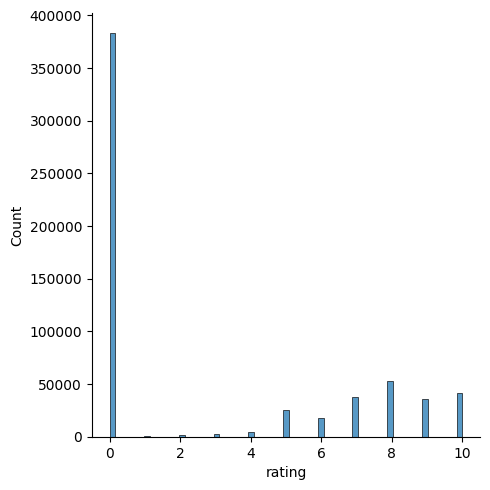

In [9]:
sns.displot(data=book_dataframe, x='rating')

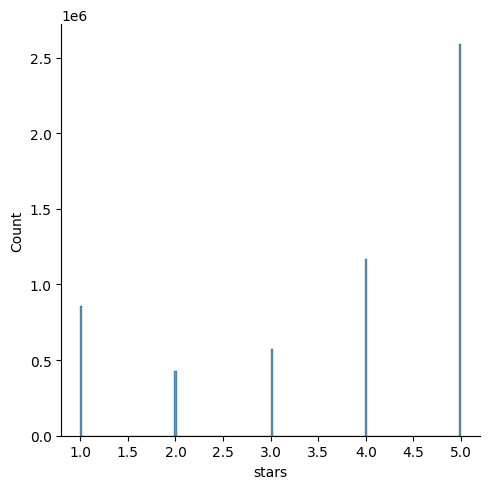

In [15]:
sns.displot(data=yelp_dataframe, x='stars')

In [34]:
yelp_dataframe.fans.value_counts()

fans
unpopular      2833512
semipopular    1841592
popular         946976
Name: count, dtype: int64

In [29]:
eta = 1
alpha = 0.05
gamma = 500
lambd = 1
n = 10
initial_wealth = eta * alpha
g_in = Group(dataset=yelp_dataset, predicates={'gender': 'M', 'fans': 'popular'})
h = HypothesisTest(aggregation='mean', null_value=3, alternative='greater', n_sample=HypothesisTest.ONE_SAMPLE)


for name, algorithm in {'cover': cover_alpha, 'covdiv': covdiv_alpha}.items():
    print(name)
    print('\t', g_in)
    G_out, wealth, cov, div, power, fdr, execution_time = run_alpha_investing(
        algorithm,
        (name == 'covdiv'),
        D=yelp_dataset,
        g_in=g_in,
        h=h,
        alpha=alpha,
        n=n,
        wealth=initial_wealth,
        gamma=gamma,
        lambd=lambd,
    )

    for g in G_out:
        print('\t\t' + str(g))
    print('\t\t\tCoverage:', coverage(G_out, g_in))
    print('\t\t\tDiversity:', diversity(G_out))
    print('\t\t\tPower:', power)
    print('\t\t\tFDR:', fdr)
    print('\t\t\tTime:', execution_time)

cover
	 fans:popular|gender:M
		category:Nightlife|fans:popular|gender:M
		category:Home Services|fans:popular|gender:M
		category:Restaurant|fans:popular|gender:M
		category:Shopping|fans:popular|gender:M
		category:Arts & Entertainment|fans:popular|gender:M
		category:Food|fans:popular|gender:M
		category:Hotels & Travel|fans:popular|gender:M
		category:Active Life|fans:popular|gender:M
		category:Automotive|fans:popular|gender:M
		city:Las Vegas|fans:popular|gender:M
			Coverage: 0.9965290598921793
			Diversity: 26.610542632387503
			Power: 1.0
			FDR: 0.0
			Time: 2.8441929817199707
covdiv
	 fans:popular|gender:M
		category:Mass Media|fans:popular|gender:M
		city:Henderson|fans:popular|gender:M
		city:Cleveland|fans:popular|gender:M
		city:Peoria|fans:popular|gender:M
		city:Calgary|fans:popular|gender:M
		city:Madison|fans:popular|gender:M
		city:Mississauga|fans:popular|gender:M
		category:Religious Organizations|fans:popular|gender:M
		city:Charlotte|fans:popular|gender:M
		cate

In [18]:
eta = 1
alpha = 0.05
gamma = 500
lambd = 1
n = 20
initial_wealth = eta * alpha
g_in = Group(dataset=yelp_dataset, predicates={'gender': 'M', 'category': 'Financial Services'})
h = HypothesisTest(aggregation='mean', null_value=3, alternative='greater', n_sample=HypothesisTest.ONE_SAMPLE)


for name, algorithm in {'cover': cover_alpha, 'covdiv': covdiv_alpha}.items():
    print(name)
    print('\t', g_in)
    G_out, wealth, cov, div, power, fdr, execution_time = run_alpha_investing(
        algorithm,
        (name == 'covdiv'),
        D=yelp_dataset,
        g_in=g_in,
        h=h,
        alpha=alpha,
        n=n,
        wealth=initial_wealth,
        gamma=gamma,
        lambd=lambd,
    )

    for g in G_out:
        print('\t\t' + str(g))
    print('\t\t\tCoverage:', coverage(G_out, g_in))
    print('\t\t\tDiversity:', diversity(G_out))
    print('\t\t\tPower:', power)
    print('\t\t\tFDR:', fdr)
    print('\t\t\tTime:', execution_time)

cover
	 category:Financial Services|gender:M
		category:Financial Services|city:Gilbert|gender:M
		category:Financial Services|city:Scottsdale|gender:M
		category:Financial Services|fans:semipopular|gender:M
		category:Financial Services|city:Henderson|gender:M
		category:Financial Services|city:Las Vegas|gender:M
		category:Financial Services|fans:popular|gender:M
			Coverage: 0.677158273381295
			Diversity: 14.480675773609322
			Power: 0.75
			FDR: 0.0
			Time: 0.20225095748901367
covdiv
	 category:Financial Services|gender:M
		category:Financial Services|city:Gilbert|gender:M
		category:Financial Services|city:Scottsdale|gender:M
		category:Financial Services|city:Henderson|gender:M
		category:Financial Services|fans:popular|gender:M
		category:Financial Services|city:Montréal|gender:M
		category:Financial Services|city:Las Vegas|gender:M
		category:Financial Services|fans:semipopular|gender:M
			Coverage: 0.679226618705036
			Diversity: 20.454956266650917
			Power: 0.875
			FDR: 0.

In [73]:
book_dataframe[book_dataframe.year_of_publication == '90s'].country.value_counts()

country
usa                   240724
canada                 31499
united kingdom          8209
australia               5438
germany                 4799
spain                   2916
portugal                1815
other                   1762
france                  1654
malaysia                1615
new zealand             1455
netherlands             1302
italy                    961
switzerland              649
austria                  454
iran                     423
finland                  345
brazil                   339
romania                  325
dominican republic       266
japan                    234
philippines              231
ireland                  182
china                    165
sweden                   160
belgium                  156
norway                   106
qatar                     81
Name: count, dtype: int64

In [74]:
eta = 1
alpha = 0.05
gamma = 500
lambd = 1
n = 10
initial_wealth = eta * alpha
g_in = Group(dataset=book_dataset, predicates={'year_of_publication': '90s', 'country': 'usa'})
h = HypothesisTest(aggregation='variance', null_value=4, alternative='greater', n_sample=HypothesisTest.ONE_SAMPLE)


for name, algorithm in {'cover': cover_alpha, 'covdiv': covdiv_alpha}.items():
    print(name)
    print('\t', g_in)
    G_out, wealth, cov, div, power, fdr, execution_time = run_alpha_investing(
        algorithm,
        (name == 'covdiv'),
        D=book_dataset,
        g_in=g_in,
        h=h,
        alpha=alpha,
        n=n,
        wealth=initial_wealth,
        gamma=gamma,
        lambd=lambd,
    )

    for g in G_out:
        print('\t\t' + str(g))
    print('\t\t\tCoverage:', coverage(G_out, g_in))
    print('\t\t\tDiversity:', diversity(G_out))
    print('\t\t\tPower:', power)
    print('\t\t\tFDR:', fdr)
    print('\t\t\tTime:', execution_time)

cover
	 country:usa|year_of_publication:90s
		age:<18|country:usa|year_of_publication:90s
		age:18-24|country:usa|year_of_publication:90s
		age:35-44|country:usa|year_of_publication:90s
		age:45-49|country:usa|year_of_publication:90s
		age:25-34|country:usa|year_of_publication:90s
		country:usa|language:es|year_of_publication:90s
		country:usa|language:other|year_of_publication:90s
		age:50-55|country:usa|year_of_publication:90s
		age:>56|country:usa|year_of_publication:90s
		country:usa|language:en|year_of_publication:90s
			Coverage: 1.0
			Diversity: 43.935457646070006
			Power: 1.0
			FDR: 0.0
			Time: 1.8419373035430908
covdiv
	 country:usa|year_of_publication:90s
		category:Computers|country:usa|year_of_publication:90s
		age:<18|country:usa|year_of_publication:90s
		country:usa|language:en|year_of_publication:90s
		country:usa|language:es|year_of_publication:90s
		country:usa|language:other|year_of_publication:90s
		age:45-49|country:usa|year_of_publication:90s
		age:35-44|countr

In [11]:
eta = 1
alpha = 0.05
gamma = 500
lambd = 1
n = 2
initial_wealth = eta * alpha

g_in = Group(dataset=movie_dataset, predicates={'age': '18-24'})
h = HypothesisTest(aggregation='mean', null_value=3.5, alternative='greater', n_sample=HypothesisTest.ONE_SAMPLE)
G_out, wealth, cov, div, power, fdr, execution_time = run_alpha_investing(
    cover_alpha,
    False,
    D=movie_dataset,
    g_in=g_in,
    h=h,
    alpha=alpha,
    n=n,
    wealth=initial_wealth,
    gamma=gamma,
)

for g in G_out:
    print('\t' + str(g))
print('Coverage:', coverage(G_out, g_in))
print('Diversity:', diversity(G_out))

	age:18-24|year:80s
	age:18-24|genre:Drama
Coverage: 1.0
Diversity: 0.02357207615593837


In [8]:
movie_dataframe.location.value_counts()

location
CA    179806
NY     69514
MN     63583
TX     51812
IL     51510
MA     44506
OH     39665
MI     37233
WA     37087
FL     28646
VA     27095
PA     26464
OR     21765
WI     21685
NJ     20823
CO     18361
GA     17467
CT     15336
NC     15169
AZ     15036
MD     14716
MO     13667
TN     12277
IN     11033
KS      8845
OK      8424
ME      8410
IA      7798
KY      6768
SC      6001
NH      5961
LA      5853
UT      5235
DC      5177
NE      4871
NM      4813
AR      4482
NV      3994
DE      3778
HI      3761
WV      3680
AL      3486
ID      2539
RI      2523
VT      2424
MT      2292
SD      1932
WY      1147
ND      1022
AK       910
PR       751
GU       679
AE       604
MS       555
AP       211
Name: count, dtype: int64